In [127]:
import pandas as pd
import numpy as np 
import os
import plotly.express as px
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
from matplotlib import pyplot
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error
import random

# For investigating timeseries data
from sklearn import preprocessing
from sklearn.model_selection import ParameterGrid
from prophet import Prophet
from statsmodels.tsa.seasonal import seasonal_decompose

# For modeling
import xgboost
from prophet import Prophet

### Loading Data

In [128]:
# Reading Data
base_path =  os.getcwd()
file_name = 'Traffic_Data.xlsx'
total_path = base_path + '//Data//' 
df = pd.read_excel(total_path + file_name, sheet_name='Sheet1')

# Filtering for just one state
df = df[df['State'] == 'Oregon']
df = df.sort_values(by = ['Date'])
df.head(10)
#print(len(df['State']))

,State,Region,STATIONS,CMILES,PMILES,Month,Month_2,Year,Date
3056,Oregon,West,153,2823,2769,January,1,2019,2019-01-01
3005,Oregon,West,143,2393,2566,February,2,2019,2019-02-01
2954,Oregon,West,153,3088,3104,March,3,2019,2019-03-01
2903,Oregon,West,152,3034,2990,April,4,2019,2019-04-01
2852,Oregon,West,147,3303,3295,May,5,2019,2019-05-01
2801,Oregon,West,154,3334,3318,June,6,2019,2019-06-01
2750,Oregon,West,153,3547,3527,July,7,2019,2019-07-01
2699,Oregon,West,152,3587,3541,August,8,2019,2019-08-01
2648,Oregon,West,155,3246,3216,September,9,2019,2019-09-01
2597,Oregon,West,157,3241,3185,October,10,2019,2019-10-01


### Plotting Data

In [129]:
fig = px.scatter(df, x="Date", y="CMILES", title = 'Miles Driven by Time')
fig.show()

### Seasonal Decomposition

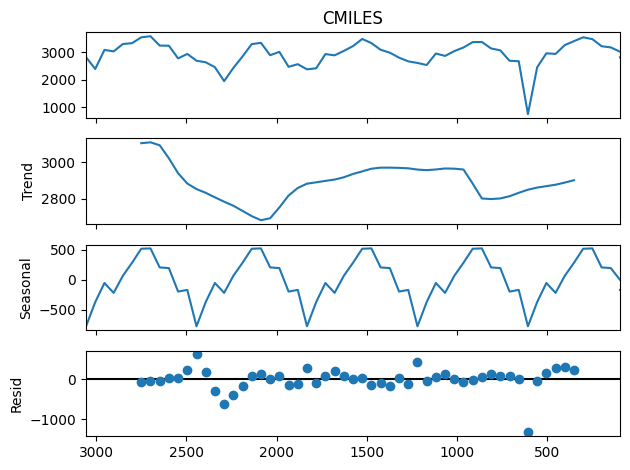

In [130]:
result = seasonal_decompose(df['CMILES'], model='additive', period=12)
result.plot()
pyplot.show()

### Creating Model

In [131]:
model = xgboost.XGBRegressor()

### Transforming Data
For our regressor to work we need to turn the problem from a timeseries problem to a regression one. We can do this by offsetting our dataset by x steps so that we can prediction time T based on teh value at T-x

In [132]:
# Defining function to convert time series problem into supervised learning problem
def convert_to_supervised(data, n_in=1, n_out=1, dropnan=True):
 
 df = pd.DataFrame(data)
 cols = list()
 # Training sequence (t-n, ... t-1)
 for i in range(0, n_in):
    print(i)
    cols.append(df.shift(i))

 # Forecast sequence (t, t+1, ... t+n)
 for i in range(0, n_out):
    print(i)
    cols.append(df.shift(-i))

 # Concatenating columns together
 agg = pd.concat(cols, axis=1)
 
 # drop rows with NaN values
 if dropnan:
    agg.dropna(inplace=True)
 return agg.values


# Function to split into test/train set based on time
def train_test_split(data, n_test):
   return data[:-n_test, :], data[-n_test:, :]

# Fit xgboost model based on histroric data and making prediction for next timestamp
def forecast(train, testX):
 
 train = np.asarray(train)
 # splitting into input/output
 x_train, y_train = train[:, :-1], train[:, -1]
 # fitting model
 model = xgboost.XGBRegressor(objective='reg:squarederror', n_estimators=1000)
 model.fit(x_train, y_train)

 # making a prediction
 y_predicted = model.predict(np.asarray([testX]))
 return y_predicted[0]


def stepwise_prediction(data, n_test):
 
 '''Iterates through timeseries data, fitting a new model for data up to
 time t and making prediction for time t+1'''
 
 predictions = list()
 # split dataset
 train, test = train_test_split(data, n_test)
 print(len(train))
 # seed history with training dataset
 history = [x for x in train] 

 # Iterating through dataset one timestep at a time
 for i in range(len(test)):
   # Creating new test and train dataset for each timestep
   testX, testy = test[i, :-1], test[i, -1]
   # Fitting model and making prediction for next step
   y_pred = forecast(history, testX)
   # store forecast in list of predictions
   predictions.append(y_pred)

 return  predictions

### Fitting Model

In [133]:
values = df['CMILES'].values
print(values)
# Transforming to time series                                                                                                                                                       
data = convert_to_supervised(values, n_in=6)
print(data.shape)
print(data)

[2823 2393 3088 3034 3303 3334 3547 3587 3246 3241 2778 2942 2694 2637
 2457 1949 2429 2850 3299 3345 2894 3017 2472 2567 2379 2418 2935 2890
 3052 3226 3488 3336 3092 2988 2805 2671 2612 2537 2956 2869 3044 3176
 3372 3376 3141 3072 2692 2676  746 2452 2964 2942 3263 3407 3549 3481
 3222 3180 2864 2817]
0
1
2
3
4
5
0
(55, 7)
[[3334. 3303. 3034. 3088. 2393. 2823. 3334.]
 [3547. 3334. 3303. 3034. 3088. 2393. 3547.]
 [3587. 3547. 3334. 3303. 3034. 3088. 3587.]
 [3246. 3587. 3547. 3334. 3303. 3034. 3246.]
 [3241. 3246. 3587. 3547. 3334. 3303. 3241.]
 [2778. 3241. 3246. 3587. 3547. 3334. 2778.]
 [2942. 2778. 3241. 3246. 3587. 3547. 2942.]
 [2694. 2942. 2778. 3241. 3246. 3587. 2694.]
 [2637. 2694. 2942. 2778. 3241. 3246. 2637.]
 [2457. 2637. 2694. 2942. 2778. 3241. 2457.]
 [1949. 2457. 2637. 2694. 2942. 2778. 1949.]
 [2429. 1949. 2457. 2637. 2694. 2942. 2429.]
 [2850. 2429. 1949. 2457. 2637. 2694. 2850.]
 [3299. 2850. 2429. 1949. 2457. 2637. 3299.]
 [3345. 3299. 2850. 2429. 1949. 2457. 3345

In [134]:
# Setting test dataset size
prediction_count = 12
prediction_dates = df['Date'].sort_values()[-prediction_count:]
print(prediction_dates)
# Making prediction with Xgboost
y_pred = stepwise_prediction(data, prediction_count)
print(y_pred)

608   2023-01-01
557   2023-02-01
506   2023-03-01
455   2023-04-01
404   2023-05-01
353   2023-06-01
302   2023-07-01
251   2023-08-01
200   2023-09-01
149   2023-10-01
47    2023-11-01
98    2023-12-01
Name: Date, dtype: datetime64[ns]
43
[1949.0082, 2428.3584, 2955.4558, 2943.1833, 3239.683, 3373.2495, 3547.1895, 3374.065, 3214.3623, 3213.9211, 2849.1855, 2803.8652]


### Analyzing Results

In [135]:
# Creating dataframe for comparing predicted/actual values
df_comparison = df[['CMILES', 'Date']]
df_comparison['Method'] = 'Actual'

# Converting xgboost predictions to dataframe
xgboost_dict = {'CMILES': y_pred,
                'Date': prediction_dates,
                'Method': 'xgboost'}
xgboost_df = pd.DataFrame.from_dict(xgboost_dict)

# Appending predictions to comparison dataframe   
df_comparison = pd.concat([df_comparison, xgboost_df], ignore_index=True)

C:\Users\seelc\AppData\Local\Temp\ipykernel_22396\1622743148.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### Graphing Actual vs Predicted Values

In [136]:
# Calculating MAPE for xgboost
xgboost_mape = round(mean_absolute_percentage_error(xgboost_df['CMILES'], 
                                              df.sort_values(by = ['Date'])[-prediction_count:]['CMILES']),3)

compare_fig = px.line(df_comparison, x = 'Date', y = 'CMILES', color='Method',
                      title = 'Predicted vs Actual Traffic, MAPE: {mape}'.format(mape = xgboost_mape))
compare_fig.show()

### Comparing XGboost with Prophet

In [137]:
prophet_df = df[['CMILES', 'Date']].copy()
prophet_df = prophet_df.rename(columns= {'CMILES':'y',
                                       'Date':'ds'}).reset_index().drop(columns=['index'])
prophet_df.head(10)

,y,ds
0,2823,2019-01-01
1,2393,2019-02-01
2,3088,2019-03-01
3,3034,2019-04-01
4,3303,2019-05-01
5,3334,2019-06-01
6,3547,2019-07-01
7,3587,2019-08-01
8,3246,2019-09-01
9,3241,2019-10-01


In [138]:
train, test = prophet_df[:len(prophet_df['y'])-prediction_count], prophet_df[-prediction_count:]
prophet_model = Prophet()
prophet_model.fit(train)
print(test)

10:44:45 - cmdstanpy - INFO - Chain [1] start processing
10:44:45 - cmdstanpy - INFO - Chain [1] done processing


       y         ds
48   746 2023-01-01
49  2452 2023-02-01
50  2964 2023-03-01
51  2942 2023-04-01
52  3263 2023-05-01
53  3407 2023-06-01
54  3549 2023-07-01
55  3481 2023-08-01
56  3222 2023-09-01
57  3180 2023-10-01
58  2864 2023-11-01
59  2817 2023-12-01


c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\Timeseries-Forecasting\.venv\Lib\site-packages\prophet\plot.py:72: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\Timeseries-Forecasting\.venv\Lib\site-packages\prophet\plot.py:73: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



           ds        trend   yhat_lower   yhat_upper  trend_lower  \
0  2023-01-01  2938.315230  2438.743682  2838.880432  2937.911443   
1  2023-02-01  2942.456612  2257.736236  2686.180347  2941.100328   
2  2023-03-01  2946.197216  2647.195355  3063.375072  2943.206879   
3  2023-04-01  2950.338598  2681.020219  3081.504233  2945.800930   
4  2023-05-01  2954.346388  2893.958973  3315.374493  2947.682055   
5  2023-06-01  2958.487770  2961.269117  3356.219595  2949.485457   
6  2023-07-01  2962.495560  3175.580991  3587.486889  2950.691035   
7  2023-08-01  2966.636943  3254.640930  3657.125275  2952.387623   
8  2023-09-01  2970.778325  3019.949662  3413.949921  2953.207169   
9  2023-10-01  2974.786115  2995.878063  3406.628694  2954.169304   
10 2023-11-01  2978.927497  2593.994206  3018.523506  2954.778122   
11 2023-12-01  2982.935287  2644.982099  3073.758381  2955.142191   

    trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0   2938.748059     -30

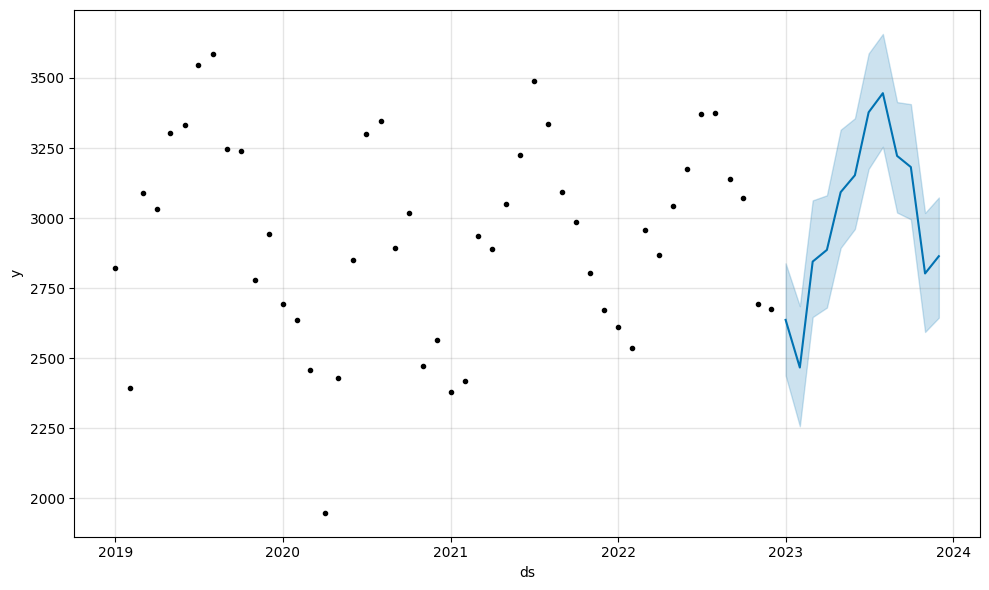

In [139]:
forecast = prophet_model.predict(test)
print(forecast)
fig1 = prophet_model.plot(forecast)

### Comparing XGboost and Prophet

In [140]:
y_pred_prophet = forecast['yhat'].values

# Converting prophet predictions to dataframe
prophet_dict = {'CMILES': y_pred_prophet,
                'Date': prediction_dates,
                'Method': 'Prophet'}
prophet_df = pd.DataFrame.from_dict(prophet_dict)

# Appending predictions to comparison dataframe   
df_comparison = pd.concat([df_comparison, prophet_df], ignore_index=True)

In [141]:
# Calculating MAPE for xprophet
prophet_mape = round(mean_absolute_percentage_error(y_pred_prophet, 
                                              df.sort_values(by = ['Date'])[-prediction_count:]['CMILES']),3)

compare_fig = px.line(df_comparison, x = 'Date', y = 'CMILES', color='Method',
                      title = 'Predicted vs Actual Traffic, XGboost MAPE: {mape_g} , Prophet MAPE: {mape_p} '.format(mape_g = xgboost_mape, mape_p = prophet_mape))
compare_fig.show()